In [1]:
%pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.1 MB/s eta 0:00:00


In [52]:
import os
import pandas as pd
import glob
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
import sys
import csv
from pandas.core.algorithms import unique
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot
from scipy.interpolate import interp2d
import folium




from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
# Path to tsv edna file
path_to_edna = '/content/gdrive/MyDrive/amazon_data/Lofi_data/BOLD_Public.19-Apr-2024.Amazon_Countries.tsv'


# Path to the folder including ecological layars
# (all tif files in the folder will be included)
path_to_ecolayers = '/content/gdrive/MyDrive/amazon_data/Lofi_data/environmental_data'


In [59]:
# Function to parse coordinates from '(x, y)' format
def parse_coordinates(coord_str):
    x, y = coord_str.replace('(', '').replace(')', '').split(',')
    return float(x.strip()), float(y.strip())


# Load eDNA samples from a TSV file, assuming it has 'latitude' and 'longitude' columns
# Specify delimiter='\t' for tab-separated values
edna_samples = pd.read_csv(path_to_edna, delimiter='\t')


# Parse the 'coord' column to separate 'longitude' and 'latitude'
edna_samples[['latitude', 'longitude']] = edna_samples['coord'].apply(
    lambda x: pd.Series(parse_coordinates(x))
)


# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(edna_samples.longitude, edna_samples.latitude)]
geo_edna = gpd.GeoDataFrame(edna_samples, geometry=geometry)


<ipython-input-59-77a73aaba9fc>:9: DtypeWarning: Columns (20,42,45,46,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  edna_samples = pd.read_csv(path_to_edna, delimiter='\t')


<ipython-input-45-47bca69c3394>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


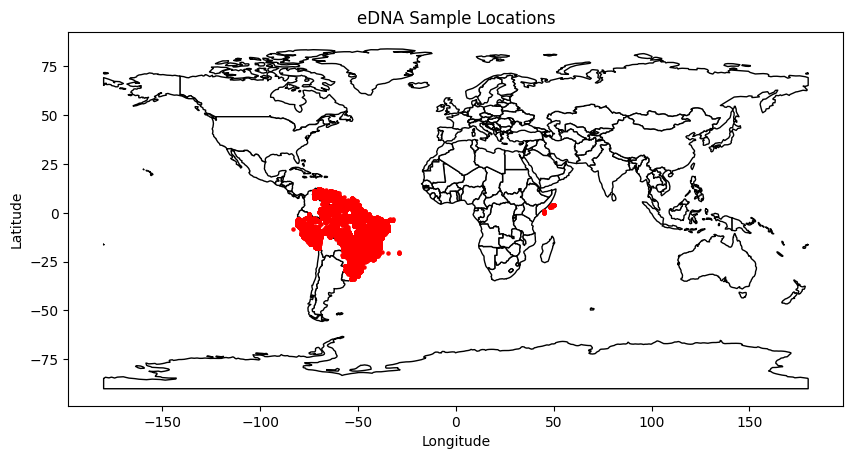

In [45]:
# Plotting the data points on a map
fig, ax = plt.subplots(figsize=(10, 10))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
geo_edna.plot(ax=ax, marker='o', color='red', markersize=5)
plt.title('eDNA Sample Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [56]:
def plot_points_on_map(df,latitude_column,latitude_value,longitude_column,longitude_value,zoom):
    location = [latitude_value,longitude_value]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.species[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],df[longitude_column].iloc[i]],popup=popup).add_to(plot)
    return(plot)

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='afmhot', vmin=vmin, vmax=vmax)
    plt.show()



In [57]:
geo_edna['latitude'] = geo_edna['latitude'].astype(float)
a = np.array(geo_edna['latitude'].values.tolist()) # 18 insted of 8
geo_edna['latitude'] = np.where(a < 10, a + 10, a).tolist()
lat = geo_edna.latitude.mean()
lon = geo_edna.longitude.mean()
plot_points_on_map(geo_edna,'latitude', lat, 'longitude', lon, 9)

In [60]:
# Function to find all TIF files in a directory, including subdirectories
def find_tif_files(directory):
    return [file for file in glob.glob(f"{directory}/**/*tif", recursive=True)]


# Function to extract raster values at given points
def get_raster_values(geo_df, raster_path):
    with rasterio.open(raster_path) as src:
        return [x[0] for x in src.sample([(geom.x, geom.y) for geom in geo_df.geometry])]



In [61]:
# Process soil layer files
soil_folder = os.path.join(path_to_ecolayers, 'soil')
soil_files = find_tif_files(soil_folder)

# Grouping files that differ only in the last seven characters before '.tif'
soil_groups = {}
for file in soil_files:
    base_name = os.path.basename(file)[:-13]  # Assumes last 13 characters are '...xxx_xxx.tif'
    if base_name not in soil_groups:
        soil_groups[base_name] = []
    soil_groups[base_name].append(file)

for group in soil_groups.values():
    mean_values = []
    for file in group:
        values = get_raster_values(geo_edna, file)
        mean_values.append(values)
    mean_values = pd.DataFrame(mean_values).mean().tolist()
    geo_edna[f'mean_{base_name}'] = mean_values

# Process bio-climatic files
bio_climatic_folder = os.path.join(path_to_ecolayers, 'bio_climatic')
bio_climatic_files = find_tif_files(bio_climatic_folder)

for file in bio_climatic_files:
    base_name = os.path.splitext(os.path.basename(file))[0]
    values = get_raster_values(geo_edna, file)
    geo_edna[base_name] = values


# Aave the DataFrame to CSV, excluding the geometry column
geo_edna.to_file("/content/gdrive/MyDrive/amazon_data/geo_eDNA_data.gpkg", driver='GPKG')

# Save the DataFrame to CSV, excluding the geometry column
geo_edna.drop('geometry', axis=1).to_csv("/content/gdrive/MyDrive/amazon_data/geo_eDNA_data.csv", index=False)


print(geo_edna.head())


   Unnamed: 0    processid    sampleid  specimenid                museumid  \
0       27883  ABCSA910-06  ROM 107817      309072          ROM:MAM:107817   
1       28948  ABECB067-06   ROM 97768      299725                   97768   
2       30197   ABFG001-08      T-2472      920194  MNHN-MO-pending number   
3       30198   ABFG003-08      T-2474      920196  MNHN-MO-pending number   
4       30199   ABFG008-08      T-2756      920201  MNHN-MO-pending number   

   fieldid                                  inst       bin_uri  \
0   F42873                  Royal Ontario Museum  BOLD:AAA8487   
1  FN33249                  Royal Ontario Museum  BOLD:ABZ9500   
2   V-1161  Museum national d'Histoire naturelle  BOLD:AAA7109   
3   V-1162  Museum national d'Histoire naturelle  BOLD:AAA7109   
4   V-1343  Museum national d'Histoire naturelle  BOLD:AAA7109   

             identification funding_src  ...  \
0  Glossophaga longirostris         NaN  ...   
1     Artibeus planirostris         Na

# NaN values in rasters

Bioclimatic and pedologic data is not available for all locations, and NaN values in the extracted rasters were filled as follows (Like SatBird):

1.   Extract rasters with NaN values. Compute the max and min values for each variable over the considered dataset.

2.   Fill NaN values with bilinear interpolation. We used scipy.interolate.interp2d function. If interpolation was not possible (less than 2 values in the raster), we left the raster with NaNs

In [62]:
from scipy.interpolate import interp2d

# Handling missing raster data
for column in geo_edna.columns:
    if column.startswith('soil') or column.startswith('bio'):
        data = geo_edna[column].values
        if np.isnan(data).all():
            continue
        nan_coords = np.where(np.isnan(data))
        x = np.arange(data.size)
        f = interp2d(x[nan_coords], x, data[nan_coords], kind='linear', fill_value="extrapolate")
        geo_edna[column].iloc[nan_coords] = f(nan_coords)

# Save the updated GeoDataFrame
geo_edna.to_file("/content/gdrive/MyDrive/amazon_data/geo_eDNA_data_clean.gpkg", driver='GPKG')

# Save the DataFrame to CSV, excluding the geometry column
geo_edna.drop('geometry', axis=1).to_csv("/content/gdrive/MyDrive/amazon_data/geo_eDNA_data_clean.csv", index=False)

print(geo_edna.head())

   Unnamed: 0    processid    sampleid  specimenid                museumid  \
0       27883  ABCSA910-06  ROM 107817      309072          ROM:MAM:107817   
1       28948  ABECB067-06   ROM 97768      299725                   97768   
2       30197   ABFG001-08      T-2472      920194  MNHN-MO-pending number   
3       30198   ABFG003-08      T-2474      920196  MNHN-MO-pending number   
4       30199   ABFG008-08      T-2756      920201  MNHN-MO-pending number   

   fieldid                                  inst       bin_uri  \
0   F42873                  Royal Ontario Museum  BOLD:AAA8487   
1  FN33249                  Royal Ontario Museum  BOLD:ABZ9500   
2   V-1161  Museum national d'Histoire naturelle  BOLD:AAA7109   
3   V-1162  Museum national d'Histoire naturelle  BOLD:AAA7109   
4   V-1343  Museum national d'Histoire naturelle  BOLD:AAA7109   

             identification funding_src  ...  \
0  Glossophaga longirostris         NaN  ...   
1     Artibeus planirostris         Na